# Orbbec Camera 2XL Depth Data Understanding

## 0. Import Library

In [1]:
from pyorbbecsdk import *
from utils import frame_to_bgr_image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import rerun as rr
import rerun.blueprint as rrb
import math

## 1. Utility Function

In [2]:
def playback_state_callback(state):
    """Callback function to handle playback state transitions."""
    global playback_finished
    if state == OBMediaState.OB_MEDIA_BEGIN:
        print("Bag player begin")
    elif state == OBMediaState.OB_MEDIA_END:
        print("Bag player end")
        playback_finished = True  # Signal that playback has finished
    elif state == OBMediaState.OB_MEDIA_PAUSED:
        print("Bag player paused")

def process_frames(bag_file):
    """
    Process the .bag file and return lists of processed images.
    
    Returns:
        depth_image_list: List of raw depth data (converted to float and scaled).
        color_image_list: List of processed color images.
        overlaid_image_list: List of images with overlay (color blended with depth colormap).
    """
    global playback_finished
    playback_finished = False  # Reset flag

    pipeline = Pipeline(bag_file)
    playback = pipeline.get_playback()
    playback.set_playback_state_callback(playback_state_callback)

    # Start the pipeline
    pipeline.start()

    depth_image_list = []
    color_image_list = []

    while not playback_finished:
        frames = pipeline.wait_for_frames(100)
        if frames is None:
            if playback_finished:
                print("All frames have been processed and converted successfully.")
                break
            continue

        # Retrieve frames once per iteration
        color_frame = frames.get_color_frame()
        depth_frame = frames.get_depth_frame()

        if depth_frame is not None:
            width = depth_frame.get_width()
            height = depth_frame.get_height()
            scale = depth_frame.get_depth_scale()

            # Process raw depth data
            depth_data = np.frombuffer(depth_frame.get_data(), dtype=np.uint16)
            depth_data = depth_data.reshape((height, width))
            depth_data = depth_data.astype(np.float32) * scale
            depth_image_list.append(depth_data)

            # Normalize and invert to obtain desired mapping (farthest = red, closest = blue)
            depth_norm = cv2.normalize(depth_data, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            inverted_depth = 255 - depth_norm
            depth_image = cv2.applyColorMap(inverted_depth, cv2.COLORMAP_JET)
        else:
            depth_image = None

        if color_frame is not None:
            width = color_frame.get_width()
            height = color_frame.get_height()

            color_data = frame_to_bgr_image(color_frame)
            color_image = cv2.resize(color_data, (width, height))
            # Convert to BGR if necessary; adjust if frame_to_bgr_image already outputs BGR
            color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
            color_image_list.append(color_image)
        else:
            color_image = None

    return depth_image_list, color_image_list

def visualize_depth(rgb_image, depth_image):
    # Visualize the depth prediction using matplotlib
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image)
    plt.title("Original Image")
    plt.axis("off")
    print("RGB Image shape:", rgb_image.shape)

    # Depth prediction
    plt.subplot(1, 2, 2)
    plt.imshow(depth_image, cmap="jet")
    plt.title("Depth Image")
    plt.axis("off")
    print("Depth Image shape:", depth_image.shape)

    plt.tight_layout()
    plt.show()

def rerun_visualization(image_list: list):
    stream = rr.new_recording("spawn", spawn=True)

    # Setup the blueprint for the layout configuration.
    blueprint = rrb.Blueprint(
        rrb.Grid(
            rrb.Vertical(
                rrb.Spatial2DView(origin='/color_image'),
            ),
        ),
        collapse_panels=True
    )

    print(f"Data shape: {image_list[0].shape}")

    # Log images to both recording streams with time sequencing.
    for idx in range(len(image_list)):
        stream.set_time_sequence("frame", idx)
        stream.log("color_image", rr.Image(image_list[idx]))

    stream.send_blueprint(blueprint)


## 2. Data Understanding

- There five different classes from the data to extracted: **Hand Open**, **Intrinsic Plan**, **Straight Fist**, **Hand Close**, and **Hook Hand**. The illustration is as follows: 

  <img src='../../IMAGES/Classes.jpg' width="500px" />

### 1. Import Data

In [4]:
bags_dir = f'./data/20250506/T2/tendon-gliding'
bags_file = []

bags_file.extend(glob.glob(os.path.join(bags_dir, '*.bag')))
print("bags_file:", bags_file)

bags_file: ['./data/20250506/T2/tendon-gliding\\Record_20250506145704.bag']


### 2. Visualize RAW `.bag` Data

- The average calculated from each data recordings is `104` obtain from given expression

  ```python
  # Using a generator expression to calculate total length
  total_data = sum(len(data["depth_images"]) for data in processed_data.values())
  print(f"Sum of data length: {total_data}")

  # Calculate the average data length directly
  average_data = total_data / len(processed_data)
  print(f"Average data length: {average_data:.2f}")
  ```

#### Orbbec Gemini 2XL Depth Camera

**Process RAW `.bag` file**

In [5]:
processed_data = {}

for idx, bag_file in enumerate(bags_file):
    print(f"Processing bag file: {bag_file}")

    # Process the frames in the bag file
    depth_images, color_images = process_frames(bag_file)

    # Store the lists in the dictionary under the key `recording_{idx}`
    processed_data[f"recording_{idx}"] = {
        "depth_images": depth_images,
        "color_images": color_images
    }

# # Now remove the first 16 frames from recording_2
# rec2 = processed_data.get("recording_2")
# if rec2:
#     rec2["depth_images"] = rec2["depth_images"][16:]
#     rec2["color_images"] = rec2["color_images"][16:]
#     print("Trimmed first 16 frames from recording_2")
# else:
#     print("recording_2 not found in processed_data")


Processing bag file: ./data/20250506/T2/tendon-gliding\Record_20250506145704.bag
Bag player begin
Bag player end
recording_2 not found in processed_data


**Visualize Color and Depth Image**

In [10]:
# Retrive the data for recording
recording_0 = processed_data.get("recording_0")
recording_1 = processed_data.get("recording_1")
recording_2 = processed_data.get("recording_2")

print(f"Length of data recording_0: {len(recording_0['depth_images'])}")
# print(f"Length of data recording_1: {len(recording_1['depth_images'])}")
# print(f"Length of data recording_2: {len(recording_2['depth_images'])}")

depth_images = recording_0["depth_images"]
color_images = recording_0["color_images"]

# visualize_depth(color_images[0], depth_images[0])
# rerun_visualization(color_images)
rerun_visualization(color_images)

Length of data recording_0: 318
Data shape: (800, 1280, 3)


**Preprocess Data (Cropping to Target Hand)**

In [ ]:
import albumentations as A
import cv2
import numpy as np

recording_0 = processed_data.get("recording_0")
recording_1 = processed_data.get("recording_1")
recording_2 = processed_data.get("recording_2")

def save_image(image, filename):
    # Convert into RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Save the image
    cv2.imwrite(filename, image)

def apply_transform(image):
    transformed = pipeline(image=image)
    return transformed['image']

pipeline = A.Compose([
    A.Crop(x_min=350, y_min=100, x_max=650, y_max=400, p=1),
])

save_image(apply_transform(recording_0["color_images"][0]), "recording_0_color_image.png")
save_image(apply_transform(recording_1["color_images"][0]), "recording_1_color_image.png")
save_image(apply_transform(recording_2["color_images"][0]), "recording_2_color_image.png")

**Segment Data into Five Classes**

In [27]:
import math

def segment_data(data, extract_config=None, recording_id=None):
    """
    Segments the input data into 5 classes of exactly 16 frames each.
    For each class region (0–7, 16–23, 32–39, 48–55, 64–71), extracts up to
    `extract_per_class` frames (configurable per recording), then pads with
    the last extracted frame to reach 16. If a region is completely empty,
    pads with the very last frame of the recording.

    Classes (start indices):
      0: Hand Open
     16: Intrinsic Plan
     32: Straight Fist
     48: Hand Close
     64: Hook Hand

    Parameters:
        data (list): A sequence of frames (length n ≥ 0).
        extract_config (dict, optional): maps recording_id → extract_per_class.
        recording_id (str, optional): the key for this recording in extract_config.

    Returns:
        dict: Mapping from each class label to a list of 16 frames.
    """
    class_labels = [
        "Hand Open",
        "Intrinsic Plan",
        "Straight Fist",
        "Hand Close",
        "Hook Hand"
    ]
    required_per_class = 16
    default_extract = 8

    # Determine per-class extract count
    if extract_config and recording_id in extract_config:
        extract_per_class = extract_config[recording_id]
    else:
        extract_per_class = default_extract

    n = len(data)
    segments = {}

    for i, label in enumerate(class_labels):
        start_idx = i * required_per_class
        end_idx = start_idx + extract_per_class

        # Extract up to `extract_per_class` frames
        extracted = data[start_idx:end_idx]

        # If region empty, seed with last frame of entire recording
        if not extracted and n > 0:
            extracted = [data[-1]]

        # Now pad so we end up with exactly 16 frames,
        # always duplicating the *last* extracted frame
        ex_len = len(extracted)
        if ex_len < required_per_class:
            pad_count = required_per_class - ex_len
            segment = extracted + [extracted[-1]] * pad_count
        else:
            segment = extracted[:required_per_class]

        print(
            f"{label}: start {start_idx}, "
            f"extracted {ex_len} frame(s), "
            f"padded to {len(segment)}"
        )
        segments[label] = segment

    return segments

def visualize_frames_matplotlib(frame_list, n_cols=10, figsize=(20, 4)):
    n_frames = len(frame_list)
    n_rows = math.ceil(n_frames / n_cols)
    fig = plt.figure(figsize=figsize)
    
    for i, frame in enumerate(frame_list):
        # Create subplot for each frame; subplot numbering starts at 1
        ax = fig.add_subplot(n_rows, n_cols, i + 1, xticks=[], yticks=[])
        ax.imshow(frame)
        # Place text using normalized axis coordinates (0 to 1) to avoid truncation
        ax.text(0.05, 0.9, f'Frame {i}', transform=ax.transAxes,
                fontsize=14, color='white', clip_on=False,
                bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
        ax.axis('off')
    
    # Adjust the layout to ensure nothing is clipped
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def visualize_frames_rerun(segmented_data):
    """
    Visualizes frames from five segmented image lists using rr and rrb libraries.
    
    The segmented_data dictionary should contain the following keys:
      - "Hand Open"
      - "Intrinsic Plan"
      - "Straight Fist"
      - "Hand Close"
      - "Hook Hand"
      
    Each key maps to a list of image frames. This function iterates over the frames 
    concurrently from each list, logs them to the recording stream with a time sequence,
    and sends the blueprint to visualize them in a grid layout.
    """
    
    # Retrieve image lists from the segmented_data dictionary
    hand_open_list     = segmented_data.get("Hand Open")
    intrinsic_plan_list = segmented_data.get("Intrinsic Plan")
    straight_fist_list = segmented_data.get("Straight Fist")
    hand_close_list    = segmented_data.get("Hand Close")
    hook_hand_list     = segmented_data.get("Hook Hand")

    print(f"data_shape: {hand_open_list[0].shape}")
    
    # Create a new recording stream with the "spawn" parameter
    stream = rr.new_recording("spawn", spawn=True)
    
    # Define the blueprint with a grid layout containing five spatial views
    blueprint = rrb.Blueprint(
        rrb.Grid(
            rrb.Spatial2DView(origin='/hand_open_image'),
            rrb.Spatial2DView(origin='/intrinsic_plan_image'),
            rrb.Spatial2DView(origin='/straight_fist_image'),
            rrb.Spatial2DView(origin='/hand_close_image'),
            rrb.Spatial2DView(origin='/hook_hand_image'),
        )
    )
    
    # Loop through all frames concurrently using zip and enumerate for proper looping.
    for idx, (hand_open, intrinsic_plan, straight_fist, hand_close, hook_hand) in enumerate(
        zip(hand_open_list, intrinsic_plan_list, straight_fist_list, hand_close_list, hook_hand_list)
    ):
        stream.set_time_sequence("frame", idx)
        stream.log("hand_open_image", rr.Image(hand_open))
        stream.log("intrinsic_plan_image", rr.Image(intrinsic_plan))
        stream.log("straight_fist_image", rr.Image(straight_fist))
        stream.log("hand_close_image", rr.Image(hand_close))
        stream.log("hook_hand_image", rr.Image(hook_hand))
    
    # Send the blueprint to complete the recording visualization
    stream.send_blueprint(blueprint)

extract_config = {
    "recording_0": 16,
    "recording_1": 8,
    "recording_2": 9
}

all_segmented = {}

for rec_id, rec_data in processed_data.items():
    color_list = rec_data["depth_images"]
    # run segmentation on depth; you can do the same for color if desired
    segments = segment_data(
        data=color_list,
        extract_config=extract_config,
        recording_id=rec_id
    )
    all_segmented[rec_id] = segments

visualize_frames_rerun(all_segmented['recording_2'])

Hand Open: start 0, extracted 16 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 16 frame(s), padded to 16
Straight Fist: start 32, extracted 16 frame(s), padded to 16
Hand Close: start 48, extracted 16 frame(s), padded to 16
Hook Hand: start 64, extracted 16 frame(s), padded to 16
Hand Open: start 0, extracted 8 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 8 frame(s), padded to 16
Straight Fist: start 32, extracted 8 frame(s), padded to 16
Hand Close: start 48, extracted 8 frame(s), padded to 16
Hook Hand: start 64, extracted 8 frame(s), padded to 16
Hand Open: start 0, extracted 9 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 9 frame(s), padded to 16
Straight Fist: start 32, extracted 9 frame(s), padded to 16
Hand Close: start 48, extracted 9 frame(s), padded to 16
Hook Hand: start 64, extracted 9 frame(s), padded to 16
data_shape: (800, 1280)


#### MiDaS 3.0

In [ ]:
from PIL import Image
import numpy as np
import requests
import torch

from transformers import DPTImageProcessor, DPTForDepthEstimation

image_processor = DPTImageProcessor.from_pretrained("Intel/dpt-hybrid-midas")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas", low_cpu_mem_usage=True)

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")

# Convert `image` and `formatted` into numpy array
image = np.array(image)
formatted = np.array(formatted)

visualize_depth(image, formatted)

## 3. Data Generation

### 1. Segment RAW `.bag` data into 5 classes and save into `.npy`

#### Image Data

**`.npy`**

In [ ]:
import os
import copy
import numpy as np
import albumentations as A

# 1) your existing transform pipeline
pipeline = A.Compose([
    A.Crop(x_min=350, y_min=100, x_max=650, y_max=400, p=1),
])

def apply_transform(image: np.ndarray) -> np.ndarray:
    image_transformed = copy.deepcopy(image)
    return pipeline(image=image_transformed)['image']

# 2) segmentation configuration: how many frames to extract per recording
extract_config = {
    "recording_0": 16,
    "recording_1": 8,
    "recording_2": 9
}

# 3) root folder that contains the 'rgb' and 'depth' subfolders
base_save_dir = r'D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402\image'

# 4) map the keys in processed_data to the desired subfolder names
modalities = {
    "color_images": "rgb",
    "depth_images": "depth",
}

for recording_name, recording in processed_data.items():
    for data_key, subfolder in modalities.items():
        # run segmentation with the updated signature
        segmented = segment_data(
            data=recording[data_key],
            extract_config=extract_config,
            recording_id=recording_name
        )

        for class_name, frames in segmented.items():
            safe_class = class_name.replace(" ", "_")
            os.makedirs(base_save_dir, exist_ok=True)  
            out_dir = os.path.join(base_save_dir, subfolder, safe_class)
            os.makedirs(out_dir, exist_ok=True)

            for idx, frame in enumerate(frames):
                tf = apply_transform(frame)

                fname = f"{recording_name}_{safe_class}_{idx:03d}.npy"
                path = os.path.join(out_dir, fname)
                np.save(path, tf)

**Visualization**

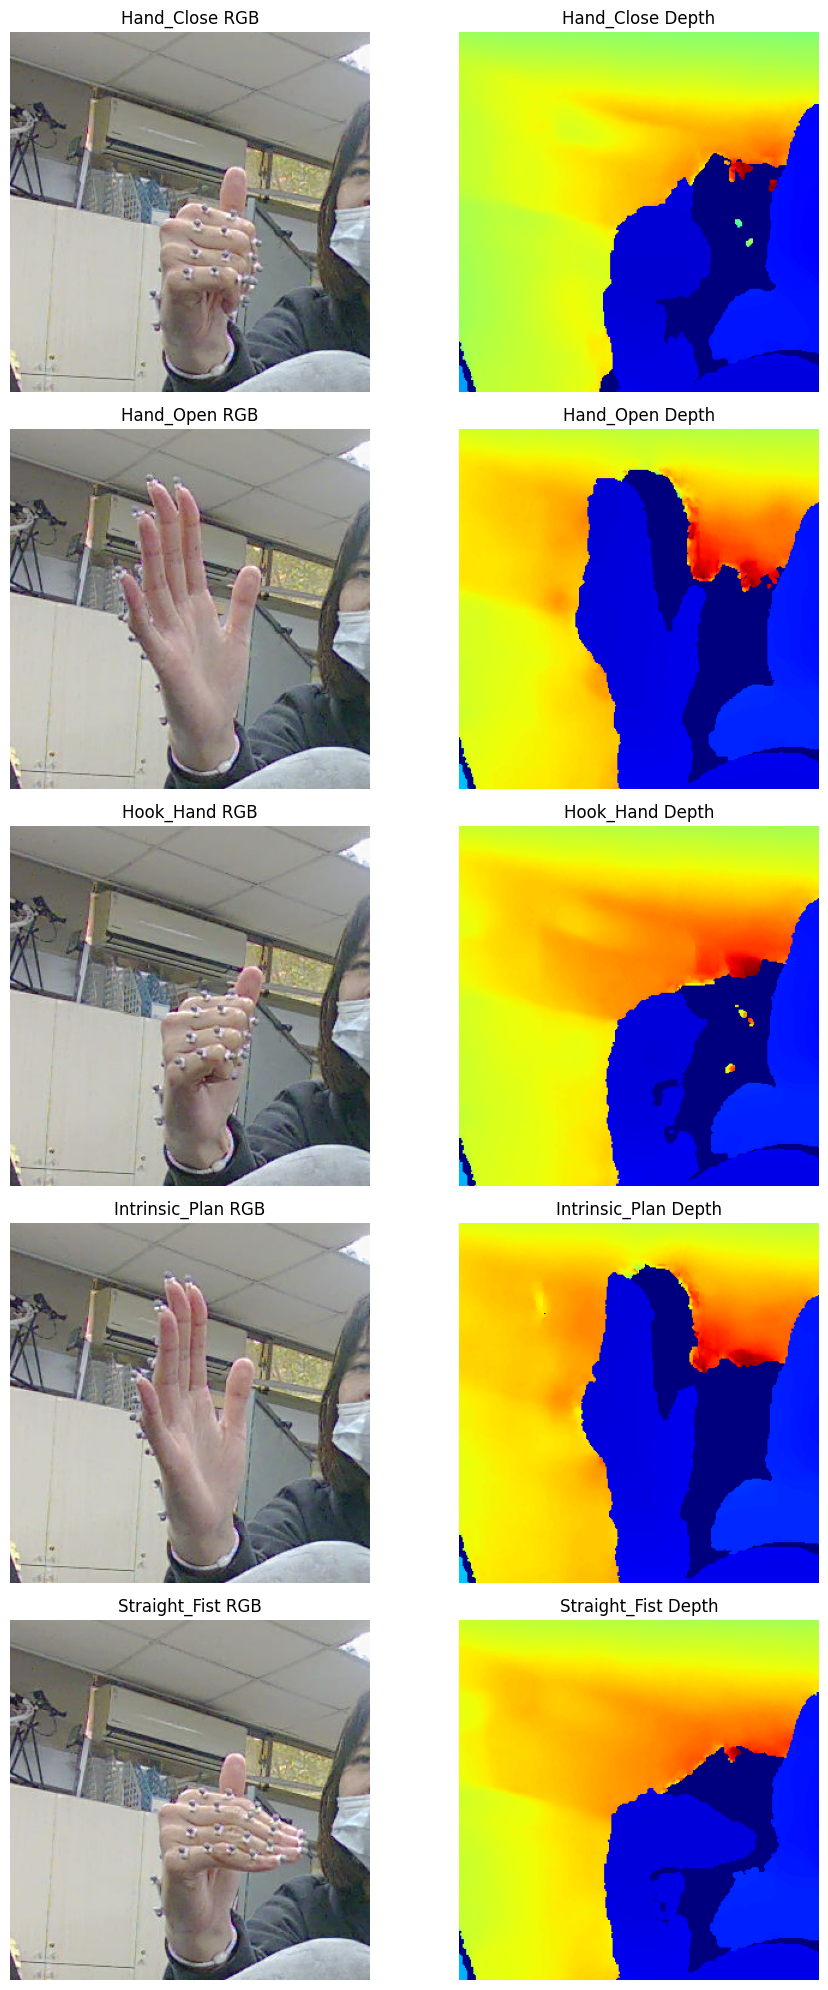

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange

def visualize_depth_examples(root_rgb: str, root_depth: str, recording_label: str):
    """
    Plot one RGB and one depth example per gesture class for a given recording.

    Args:
        root_rgb: Path to RGB data folder (contains class subfolders).
        root_depth: Path to depth data folder (contains class subfolders).
        recording_label: Prefix for files, e.g. 'recording_0'.
    """
    # Define gesture classes
    classes = ["Hand_Close", "Hand_Open", "Hook_Hand", "Intrinsic_Plan", "Straight_Fist"]
    n = len(classes)

    # Prepare figure with n rows and 2 columns
    fig, axes = plt.subplots(n, 2, figsize=(10, 4 * n))

    for i, cls in enumerate(classes):
        # Build file names
        fname = f"{recording_label}_{cls}_000.npy"
        rgb_path = os.path.join(root_rgb, cls, fname)
        depth_path = os.path.join(root_depth, cls, fname)

        # Load arrays
        if not os.path.isfile(rgb_path):
            raise FileNotFoundError(f"RGB file not found: {rgb_path}")
        if not os.path.isfile(depth_path):
            raise FileNotFoundError(f"Depth file not found: {depth_path}")

        rgb_image = np.load(rgb_path)
        depth_image = np.load(depth_path)

        # Rearrange RGB if channels-first
        if rgb_image.ndim == 3 and rgb_image.shape[0] in (1, 3, 4):
            rgb_image = rearrange(rgb_image, 'c h w -> h w c')

        # Plot RGB
        ax_rgb = axes[i, 0]
        ax_rgb.imshow(rgb_image)
        ax_rgb.set_title(f"{cls} RGB")
        ax_rgb.axis('off')

        # Plot depth
        ax_depth = axes[i, 1]
        ax_depth.imshow(depth_image, cmap='jet')
        ax_depth.set_title(f"{cls} Depth")
        ax_depth.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
ROOT_RGB = r"D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402\image\rgb"
ROOT_DEPTH = r"D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402\image\depth"
RECORDING = "recording_0"  # choose recording_0, recording_1, etc.
visualize_depth_examples(ROOT_RGB, ROOT_DEPTH, RECORDING)

**PNG**

In [28]:
import os
import copy
import numpy as np
import albumentations as A
from PIL import Image

# 1) your existing transform pipeline
pipeline = A.Compose([
    A.Crop(x_min=350, y_min=100, x_max=650, y_max=400, p=1),
])

def apply_transform(image: np.ndarray) -> np.ndarray:
    image_transformed = copy.deepcopy(image)
    return pipeline(image=image_transformed)['image']

# 2) segmentation configuration (how many frames to extract per recording)
extract_config = {
    "recording_0": 16,
    "recording_1": 8,
    "recording_2": 9
}

# 3) save each frame as .png
base_save_dir = r'D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402\image_png'

for recording_name, recording in processed_data.items():
    # run segmentation with updated signature
    segmented = segment_data(
        data=recording['color_images'],
        extract_config=extract_config,
        recording_id=recording_name
    )

    for class_name, frames in segmented.items():
        safe_class = class_name.replace(" ", "_")
        os.makedirs(base_save_dir, exist_ok=True)  # ensure base directory exists
        out_dir = os.path.join(base_save_dir, safe_class)
        os.makedirs(out_dir, exist_ok=True)

        for idx, frame in enumerate(frames):
            tf = apply_transform(frame)               # H×W×3 uint8 or float
            img = Image.fromarray(tf)
            fname = f"{recording_name}_{safe_class}_{idx:03d}.png"
            img.save(os.path.join(out_dir, fname))

Hand Open: start 0, extracted 16 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 16 frame(s), padded to 16
Straight Fist: start 32, extracted 16 frame(s), padded to 16
Hand Close: start 48, extracted 16 frame(s), padded to 16
Hook Hand: start 64, extracted 16 frame(s), padded to 16
Hand Open: start 0, extracted 8 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 8 frame(s), padded to 16
Straight Fist: start 32, extracted 8 frame(s), padded to 16
Hand Close: start 48, extracted 8 frame(s), padded to 16
Hook Hand: start 64, extracted 8 frame(s), padded to 16
Hand Open: start 0, extracted 9 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 9 frame(s), padded to 16
Straight Fist: start 32, extracted 9 frame(s), padded to 16
Hand Close: start 48, extracted 9 frame(s), padded to 16
Hook Hand: start 64, extracted 9 frame(s), padded to 16


#### Video Data

**`.npy`**

In [23]:
import os
import copy
import numpy as np
import albumentations as A
import imageio
from typing import Dict

# 1) your existing transform pipeline
pipeline = A.Compose([
    A.Crop(x_min=350, y_min=100, x_max=650, y_max=400, p=1),
])

def apply_transform(image: np.ndarray) -> np.ndarray:
    image_transformed = copy.deepcopy(image)
    return pipeline(image=image_transformed)['image']

# 2) how many frames to extract per recording
extract_config: Dict[str, int] = {
    "recording_0": 16,
    "recording_1": 8,
    "recording_2": 8,
}

# 3) where to save the stacked videos / arrays
base_save_dir = r'D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402\video'

modalities = {
    "color_images": "rgb",
    "depth_images": "depth",
}

for recording_name, recording in processed_data.items():
    for data_key, subfolder in modalities.items():
        # segment with updated signature
        segmented = segment_data(
            data=recording[data_key],
            extract_config=extract_config,
            recording_id=recording_name
        )
        
        for class_name, frames in segmented.items():
            safe_class = class_name.replace(" ", "_")
            out_dir = os.path.join(base_save_dir, subfolder, safe_class)
            os.makedirs(out_dir, exist_ok=True)

            # transform each frame
            transformed_frames = []
            for frame in frames:
                tf = apply_transform(frame)
                transformed_frames.append(tf)

            # stack frames
            clip = np.stack(transformed_frames, axis=0)  # shape = (T, H, W, C) or (T, H, W)

            # --- save as .npy ---
            if subfolder == "rgb":
                # reorder to (T, C, H, W)
                clip_npy = clip.transpose(0, 3, 1, 2)
            else:
                # depth: keep as (T, H, W)
                clip_npy = clip
            npy_path = os.path.join(out_dir, f"{recording_name}_{safe_class}.npy")
            np.save(npy_path, clip_npy)

            # # --- for RGB only: write MP4 ---
            # if subfolder == "rgb":
            #     mp4_path = os.path.join(out_dir, f"{recording_name}_{safe_class}.mp4")
            #     with imageio.get_writer(mp4_path, fps=10, codec="libx264") as writer:
            #         # feed full list of H×W×3 frames
            #         writer.append_data(transformed_frames)


Hand Open: start 0, extracted 16 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 16 frame(s), padded to 16
Straight Fist: start 32, extracted 16 frame(s), padded to 16
Hand Close: start 48, extracted 16 frame(s), padded to 16
Hook Hand: start 64, extracted 16 frame(s), padded to 16
Hand Open: start 0, extracted 16 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 16 frame(s), padded to 16
Straight Fist: start 32, extracted 16 frame(s), padded to 16
Hand Close: start 48, extracted 16 frame(s), padded to 16
Hook Hand: start 64, extracted 16 frame(s), padded to 16
Hand Open: start 0, extracted 8 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 8 frame(s), padded to 16
Straight Fist: start 32, extracted 8 frame(s), padded to 16
Hand Close: start 48, extracted 8 frame(s), padded to 16
Hook Hand: start 64, extracted 8 frame(s), padded to 16
Hand Open: start 0, extracted 8 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 8 frame(s), padded to 16
Straigh

**Visualization**

In [26]:
from einops import rearrange

def visualize_frames_rerun(data_root: str, recording_label: str):
    """
    Visualize a specified recording across all gesture classes using Rerun.
    Automatically rearranges RGB frames from (C, H, W) to (H, W, C); leaves depth frames (H, W) intact.

    Args:
        data_root: Root directory containing class subfolders.
        recording_label: Prefix for recording files (e.g. 'recording_1').
    """
    # Define the gesture classes (folder names)
    classes = ["Hand_Open", "Intrinsic_Plan", "Straight_Fist", "Hand_Close", "Hook_Hand"]
    segmented_data = {}

    # Load and preprocess each class's recording
    for cls in classes:
        folder_path = os.path.join(data_root, cls)
        file_path = os.path.join(folder_path, f"{recording_label}_{cls}.npy")
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"Expected file not found: {file_path}")

        data = np.load(file_path)
        # data shape: (T, C, H, W) for RGB or (T, H, W) for depth
        frames = []
        for t in range(data.shape[0]):
            frame = data[t]
            if frame.ndim == 3:
                # RGB: rearrange channels
                frame = rearrange(frame, 'c h w -> h w c')
            elif frame.ndim == 2:
                # Depth: keep as is
                pass
            else:
                raise ValueError(f"Unrecognized frame shape {frame.shape} in {file_path}")
            frames.append(frame)
        segmented_data[cls] = frames

    # Initialize Rerun recording
    stream = rr.new_recording("spawn", spawn=True)

    # Build grid blueprint dynamically
    views = [rrb.Spatial2DView(origin=f"/{cls.lower()}_image") for cls in classes]
    blueprint = rrb.Blueprint(rrb.Grid(*views))

    # Stream frames over time for each class
    num_frames = len(segmented_data[classes[0]])
    for idx in range(num_frames):
        stream.set_time_sequence("frame", idx)
        for cls in classes:
            key = f"{cls.lower()}_image"
            frame = segmented_data[cls][idx]
            stream.log(key, rr.Image(frame))

    # Finalize layout
    stream.send_blueprint(blueprint)

ROOT = r"D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402\video\depth"      
RECORDING = "recording_1"   
visualize_frames_rerun(ROOT, RECORDING)

**`.mp4`**

In [ ]:
import os
import copy
import numpy as np
import albumentations as A
import imageio

# 1) your existing transform pipeline
pipeline = A.Compose([
    A.Crop(x_min=350, y_min=100, x_max=650, y_max=400, p=1),
])

def apply_transform(image: np.ndarray) -> np.ndarray:
    image_transformed = copy.deepcopy(image)
    return pipeline(image=image_transformed)['image']

# 2) segmentation configuration (how many frames to extract per recording)
extract_config = {
    "recording_0": 16,
    "recording_1": 8,
    "recording_2": 10
}

# 3) write out entire clip as an MP4 (fixed to avoid the “row iteration” bug)
base_save_dir = r'D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402\video_mp4'

for recording_name, recording in processed_data.items():
    # run segmentation with the updated signature
    segmented = segment_data(
        data=recording['color_images'],
        extract_config=extract_config,
        recording_id=recording_name
    )

    for class_name, frames in segmented.items():
        safe_class = class_name.replace(" ", "_")
        out_dir = os.path.join(base_save_dir, safe_class)
        os.makedirs(out_dir, exist_ok=True)

        # collect all transformed frames
        transformed = []
        for frame in frames:
            tf = apply_transform(frame)
            # ensure uint8 H×W×3
            if tf.dtype != np.uint8:
                tf = (tf * 255).astype(np.uint8)
            transformed.append(tf)

        # write MP4 in one call so PyAV sees full-frame arrays
        video_path = os.path.join(out_dir, f"{recording_name}_{safe_class}.mp4")
        with imageio.get_writer(video_path, fps=10, codec='libx264') as writer:
            writer.append_data(transformed)
